In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import cudf as cu
from cuml.decomposition import PCA as cuPCA
from cuml.neighbors import KNeighborsClassifier as cuKNeighborsClassifier
from cuml.svm import SVC as cuSVC, LinearSVC as cuLinearSVC
from cuml import RandomForestClassifier as cuRandomForestClassifier
from cuml.model_selection import train_test_split as cuTrainTestSplit

## CALCULATE METRICS

In [2]:
def getConfusionMatrix(labels: np.ndarray, predictions: np.ndarray):
    confusion = dict()
    confusion["TP"] = np.sum(labels & predictions)
    confusion["TN"] = np.sum(~labels & ~predictions)
    confusion["FP"] = np.sum(~labels & predictions)
    confusion["FN"] = np.sum(labels & ~predictions)
    return confusion

def getMetrics(confusion):
    metrics = dict()
    metrics["accuracy"] = (confusion["TP"] + confusion["TN"]) / (confusion["TP"] + confusion["TN"] + confusion["FP"] + confusion["FN"])
    metrics["precision"] = confusion["TP"] / (confusion["TP"] + confusion["FP"])
    metrics["recall"] = confusion["TP"] / (confusion["TP"] + confusion["FN"])
    metrics["f1"] = 2 * (metrics["precision"] * metrics["recall"]) / (metrics["precision"] + metrics["recall"])
    return metrics

def printMetrics(confusion):
    print("Accuracy: \t", confusion["accuracy"])
    print("Precision: \t", confusion["precision"])
    print("Recall: \t", confusion["recall"])
    print("F1: \t\t", confusion["f1"])

## LOAD DATA CPU

In [3]:
covid = pd.read_parquet('covidClean.parquet')

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
            "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
            "DEATH_DATE", "ORIGIN_COUNTRY"]
covid = covid.drop(columns = toRemove)
covid = covid.drop(columns= ["DIED", "INTUBED", "ICU"])

labels = covid["AT_RISK"]
covid = covid.drop(columns = ["AT_RISK"])

<Axes: ylabel='Density'>

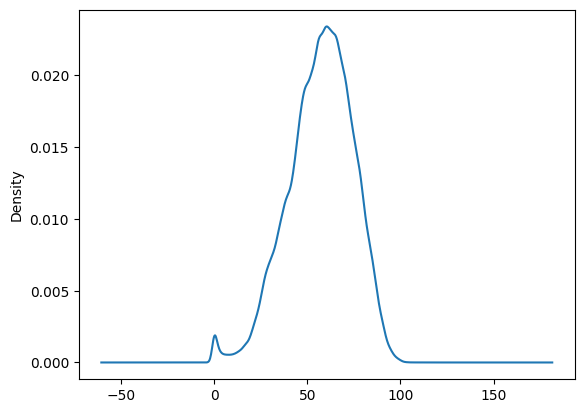

In [11]:
# for col in covid.columns:
#     covid[col].hist()
#     plt.savefig("Temp/" + col + ".png")

covid.AGE.astype("int").plot(kind="kde")

## Load Data GPU

In [5]:
cuCovid = cu.read_parquet('covidClean.parquet')

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
        "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
        "DEATH_DATE", "ORIGIN_COUNTRY"]
cuCovid = cuCovid.drop(columns = toRemove)
cuCovid = cuCovid.drop(columns= ["DIED", "INTUBED", "ICU"])
cuCovid = cuCovid.astype("float32")

labels = cuCovid["AT_RISK"]
covidX = cuCovid.drop(columns = ["AT_RISK"])

In [6]:
pca = cuPCA(n_components=2)

transformedX = pca.fit_transform(covidX)

In [7]:
cuTrainingX, cuTestX, cuTrainingY, cuTestY = cuTrainTestSplit(transformedX, labels, test_size=0.25)

cuTestY = cuTestY.to_pandas().to_numpy().astype("bool")
cuTrainY = cuTrainingY.to_pandas().to_numpy().astype("bool")

In [8]:
def findBestK(lower, upper, metric="accuracy"):
    median = (lower + upper) // 2
    if lower == median:
        return lower
    
    results = dict()
    for k in [lower, median, upper]:
        print("K: ", k)
        knn = cuKNeighborsClassifier(n_neighbors=k)
        knn.fit(cuTrainingX, cuTrainingY)
        predicted = knn.predict(cuTestX)
        
        predicted = predicted.to_pandas().to_numpy().astype("bool")
        results[k] = getMetrics(getConfusionMatrix(cuTestY, predicted))[metric]

    if results[median] > results[lower]:
        return findBestK(median, upper, metric)
    else:
        return findBestK(lower, median, metric)

#!----------------------------------------------
    
bestK = findBestK(1, 1000, "f1")
print("Best K: ", bestK)

K:  1
K:  500
K:  1000
K:  500
K:  750
K:  1000
K:  500
K:  625
K:  750
K:  500
K:  562
K:  625
K:  500
K:  531
K:  562
K:  500
K:  515
K:  531
K:  500
K:  507
K:  515
K:  507
K:  511
K:  515
K:  507
K:  509
K:  511
K:  507
K:  508
K:  509
Best K:  507


In [11]:
knn = cuKNeighborsClassifier(n_neighbors=bestK)

knn.fit(cuTrainingX, cuTrainingY)
knnPredictions = knn.predict(cuTestX)

knnPredictions = knnPredictions.to_pandas().to_numpy().astype("bool")

metrics = getMetrics(getConfusionMatrix(cuTestY, knnPredictions))

print("KNN")
printMetrics(metrics)

KNN
Accuracy: 	 0.6365702384616896
Precision: 	 0.6261350531277642
Recall: 	 0.7167465586629412
F1: 		 0.6683837810380375
